# cmip Impacts 

This file makes lots of contour plots for rainfall and temperature anomalies under different individal and compound event types



In [1]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
%run helpers/impactPlots.ipynb


In [2]:
import xarray
import numpy
import cartopy.crs as ccrs


In [3]:
indexSet='ecCombinedDmiSam'
resultsDir='results/cmipImpact/'

# Import Events

In [4]:
allEvents=xarray.open_dataset('results/cmipEcEvents.nc')

In [5]:
allEvents

<xarray.Dataset>
Dimensions:     (experiment: 2, fire: 2, model: 37, year: 5341)
Coordinates:
  * experiment  (experiment) object 'piControl' 'ssp585'
  * year        (year) int64 1 2 3 4 5 6 7 ... 7888 7889 7890 7891 7892 7893
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * fire        (fire) object 'pos' 'neg'
Data variables:
    cIndex      (fire, model, experiment, year) float64 ...
    eIndex      (fire, model, experiment, year) float64 ...
    ecCombined  (fire, model, experiment, year) float64 ...
    samWinter   (fire, experiment, model, year) float64 ...
    nino3       (fire, experiment, model, year) float64 ...
    nino4       (fire, experiment, model, year) float64 ...
    dmi         (fire, experiment, model, year) float64 ...
    nino34      (fire, experiment, model, year) float64 ...
    samSummer   (fire, experiment, model, year) float64 ...
    eastIO      (fire, experiment, model, year) float64 ...

# Get Pr and Ts

Open total rainfall and temp means (from Pi Control)

In [6]:
meanXr=xarray.load_dataset('results/cmip6PrTsMeans.nc')

And open the seasonal anomalies

In [7]:
impactXr=xarray.concat(
    [xarray.open_dataset(
                'results/cmipSeasonPrTs/'+iModel+'ssp585.nc'
    ).sel(year=range(1850,2099)) for iModel in _model.scenarioMip[:,1]],
    'model', 
    coords='minimal', 
    compat='override'
).drop('height')

In [8]:
prXr=xarray.Dataset()
prXr['Winter Rain']=(impactXr.prWinter/(meanXr['prWinter']+meanXr['prSummer'])*100)
prXr['Summer Rain']=(impactXr.prSummer/(meanXr['prWinter']+meanXr['prSummer'])*100)

tsXr=(impactXr[['tsWinter','tsSummer']])
tsXr=tsXr.rename({'tsWinter':'Winter Temp','tsSummer':'Summer Temp'})

In [9]:
# A function to trim to the area of interest for this study
def domain(ds):
    return ds.where(
    (ds.lat<-28)
        *(ds.lat>-39)
        *(ds.lon>144)
        *(ds.lon<155),
    drop=True
)
    
    

I am calculating rainfall trends as a percent of the annual rain fall, by austral season

In [12]:
%run utils/emergence.ipynb

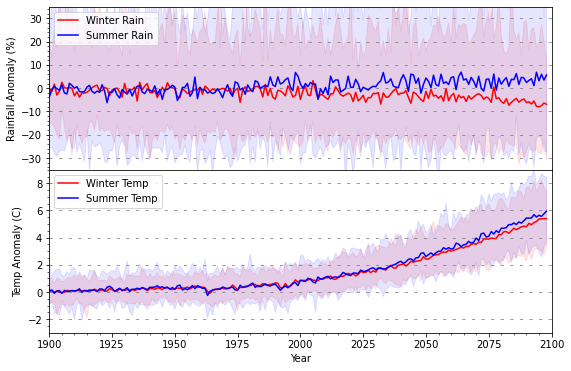

In [13]:
plt.figure(figsize=(9,6))

plt.subplot(2,1,1)

overlaidEmergePlot(domain(prXr).mean(['lon','lat']),)
plt.legend(loc='upper left')
plt.ylabel('Rainfall Anomaly (%)')
plt.xlim([1900,2100])
plt.ylim([-35,35])
plt.xticks([])
plt.grid(axis='y', color='grey', dashes=[4,8])


plt.subplot(2,1,2)

overlaidEmergePlot(domain(tsXr).mean(['lon','lat']))
plt.legend(loc='upper left')
plt.xlim([1900,2100])
plt.ylim([-3,9])
plt.ylabel('Temp Anomaly (C)')
plt.grid(axis='y', color='grey', dashes=[4,8])


plt.subplots_adjust(hspace=0)


plt.savefig('figures/cmip6RainTempTrends.pdf')

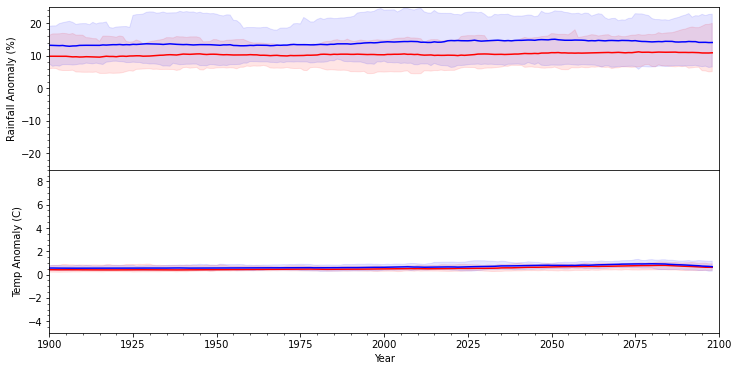

In [14]:
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)

overlaidEmergePlot(
        domain(prXr).mean(['lon','lat']).rolling(year=30,min_periods=15,center=True).std('year'),
)
plt.ylabel('Rainfall Anomaly (%)')
plt.xlim([1900,2100])
plt.ylim([-25,25])
plt.xticks([])

plt.subplot(2,1,2)

overlaidEmergePlot(
    domain(tsXr).mean(['lon','lat']).rolling(year=30,min_periods=15,center=True).std('year')
)
plt.xlim([1900,2100])
plt.ylim([-5,9])
plt.ylabel('Temp Anomaly (C)')

plt.subplots_adjust(hspace=0)


#plt.savefig('results/cmip6RainTempTrends.pdf')

{'whiskers': [<matplotlib.lines.Line2D at 0x14e2666d5700>,
 'caps': [<matplotlib.lines.Line2D at 0x14e2666d5e20>,
 'boxes': [<matplotlib.lines.Line2D at 0x14e2666d5310>],
 'medians': [<matplotlib.lines.Line2D at 0x14e2666e2580>],
 'fliers': [<matplotlib.lines.Line2D at 0x14e2666e2910>],
 'means': []}

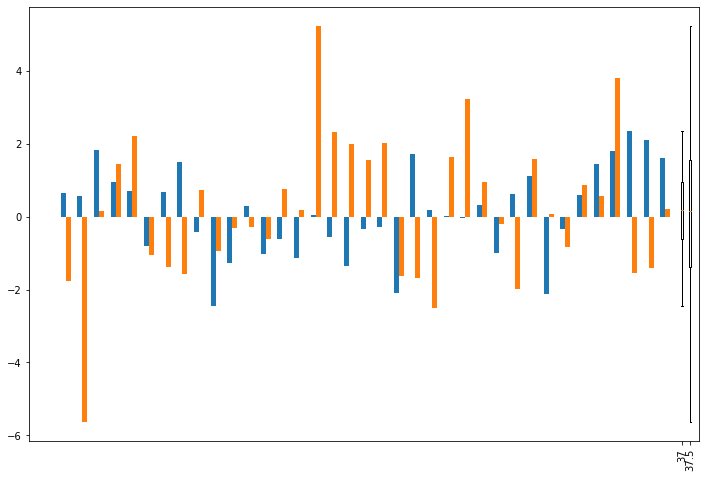

In [15]:
plotData=prXr['Summer Rain'].mean(['lon','lat'])

plt.figure(figsize=(12,8))

plt.bar(
    plotData.model, 
    plotData.sel(year=slice(1950,1999)).mean('year'),
    width=-0.3,
    align='edge'
)
junk=plt.xticks(rotation=90)
junk,models=plt.xticks()

plt.boxplot(
    plotData.sel(year=slice(1950,1999)).mean('year'), 
    positions=[(len(plotData.model.values))],
)

plt.bar(
    plotData.model, 
    plotData.sel(year=slice(2050,2099)).mean('year'),
    width=0.3,
    align='edge'
)

plt.boxplot(
    plotData.sel(year=slice(2050,2099)).mean('year'), 
    positions=[(len(plotData.model.values))+0.5],
)



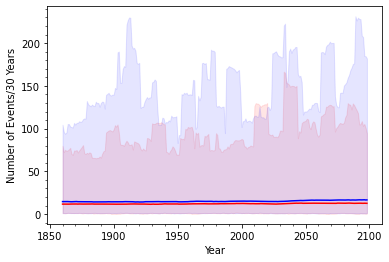

In [16]:
overlaidEmergePlot(prXr.rolling(year=11).std('year'))

# Mean state change

Mean rainfall anomaly for all models with one event

In [17]:
%run helpers/impactPlots.ipynb

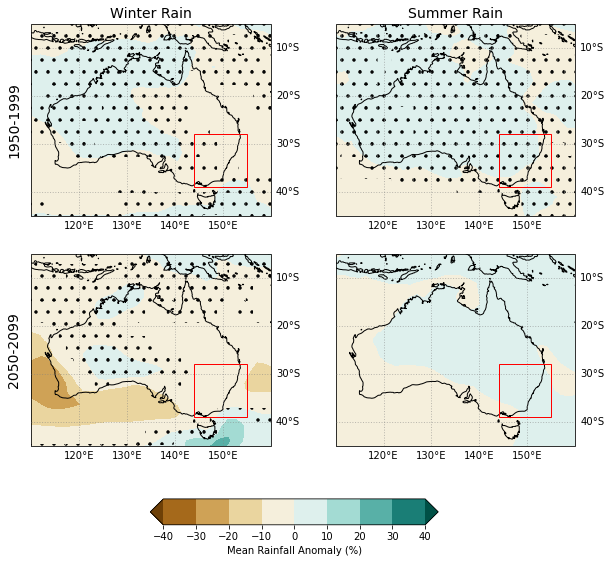

In [18]:
fig=plt.figure(figsize=(10,12))
import matplotlib.cm as cm
import matplotlib.colorbar as cb

#make a sub plot
ax=fig.add_subplot(
    3, 2,  1, projection=ccrs.PlateCarree()
)
plotAnom(
    prXr['Winter Rain'].sel(year=slice(1950,1999)).mean(['model','year']),
    ax, 
)
plotStipling(
    prXr['Winter Rain'].sel(year=slice(1950,1999)).mean(['year']),
    ax, 
)
plt.ylim([-45,-5])
plt.xlim([110,160])
ax.text(
    -0.1, 0.5,  #xy relative to bottom left of axis
    '1950-1999',
    rotation='vertical', 
    transform=ax.transAxes, 
    verticalalignment='center', 
    fontsize=14
)
plt.title('Winter Rain',{'fontsize':14})
ax=fig.add_subplot(
    3, 2,  3, projection=ccrs.PlateCarree()
)
plotAnom(
    prXr['Winter Rain'].sel(year=slice(2050,2099)).mean(['model','year']),
    ax, 
)
plotStipling(
    prXr['Winter Rain'].sel(year=slice(2050,2099)).mean(['year']),
    ax, 
)
plt.ylim([-45,-5])
plt.xlim([110,160])
ax.text(
    -0.1, 0.5,  #xy relative to bottom left of axis
    '2050-2099',
    rotation='vertical', 
    transform=ax.transAxes, 
    verticalalignment='center', 
    fontsize=14
)

ax=fig.add_subplot(
    3, 2,  2, projection=ccrs.PlateCarree()
)
plotAnom(
    prXr['Summer Rain'].sel(year=slice(1950,1999)).mean(['model','year']),
    ax, 
)
plotStipling(
    prXr['Summer Rain'].sel(year=slice(1950,1999)).mean(['year']),
    ax, 
)

plt.ylim([-45,-5])
plt.xlim([110,160])
plt.title('Summer Rain',{'fontsize':14})

ax=fig.add_subplot(
    3, 2,  4, projection=ccrs.PlateCarree()
)
cs=plotAnom(
    prXr['Summer Rain'].sel(year=slice(2050,2099)).mean(['model','year']),
    ax, 
)
plt.ylim([-45,-5])
plt.xlim([110,160])

ax=fig.add_axes([0.3,0.3,0.4,0.03])
cbar=plt.colorbar(
    cm.ScalarMappable(cs.norm,cs.cmap),
    orientation='horizontal', 
    cax=ax, 
    extend='both', 
    boundaries=cs.get_array(), 
    label = 'Mean Rainfall Anomaly (%)',
)


plt.savefig('figures/cmip6RainSpatialTrends.pdf', bbox_inches='tight')
    

# Single event impacts

In [10]:
fireEventsXr=allEvents.sel(experiment='ssp585', year=range(1850,2099),drop=True)

In [11]:
#temperature gets detrended
trendXr=tsXr.rolling(year=31,min_periods=15,center=True).mean('year')
detrendTsXr=(tsXr-trendXr)

In [12]:
eventsList=['ecCombined','dmi','samWinter','samSummer']
maskXr = (fireEventsXr[eventsList]==1)
everythingXr=(fireEventsXr['nino34'].isnull()==False)
everythingXr.name='everything'

Fire:pos
winter


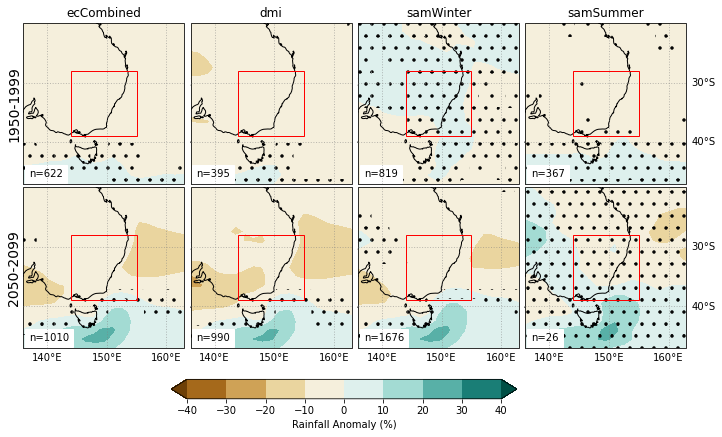

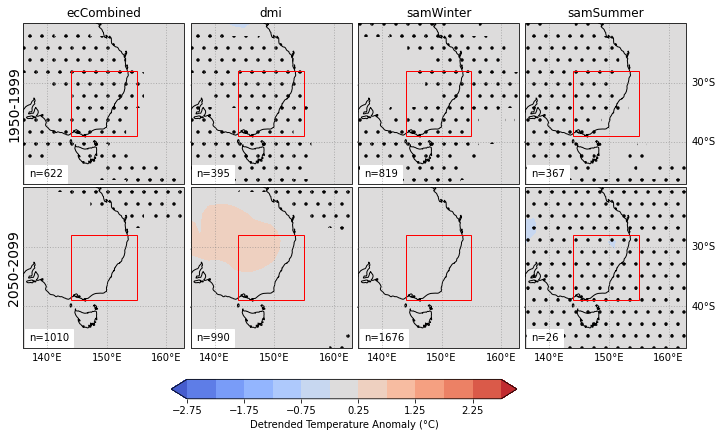

summer


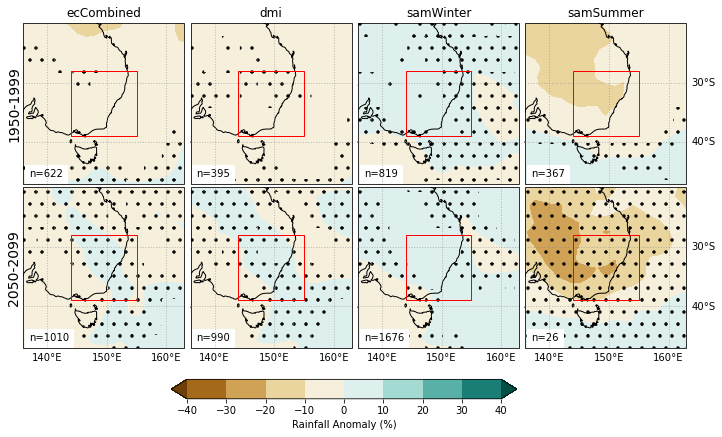

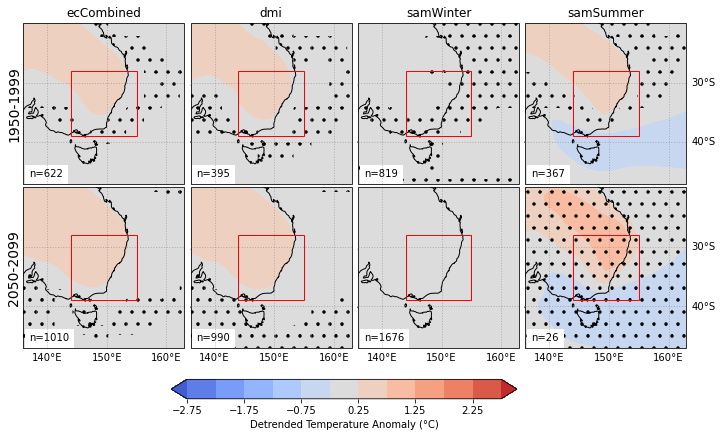

Fire:neg
winter


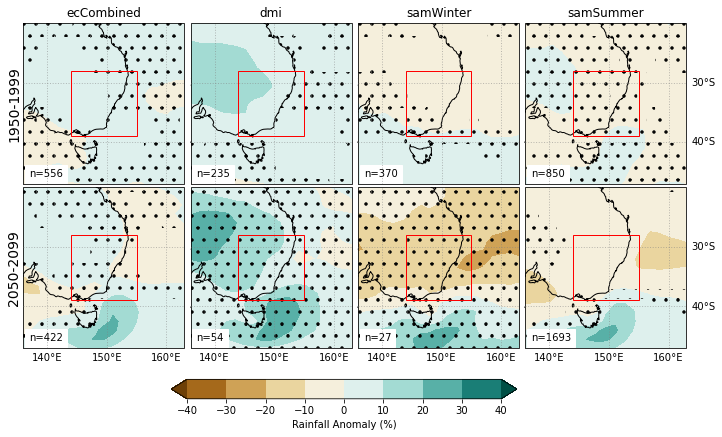

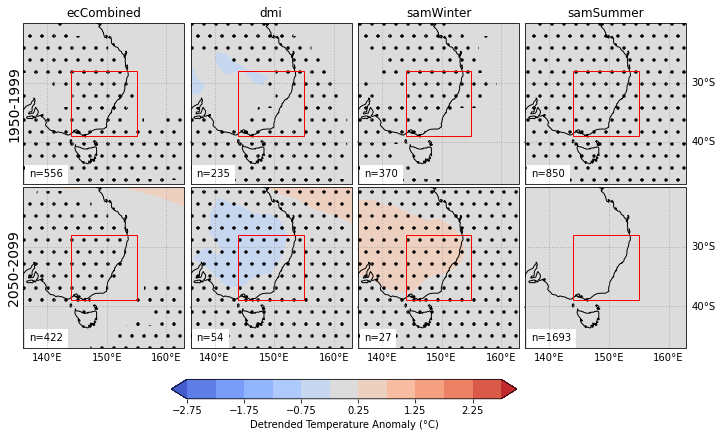

summer


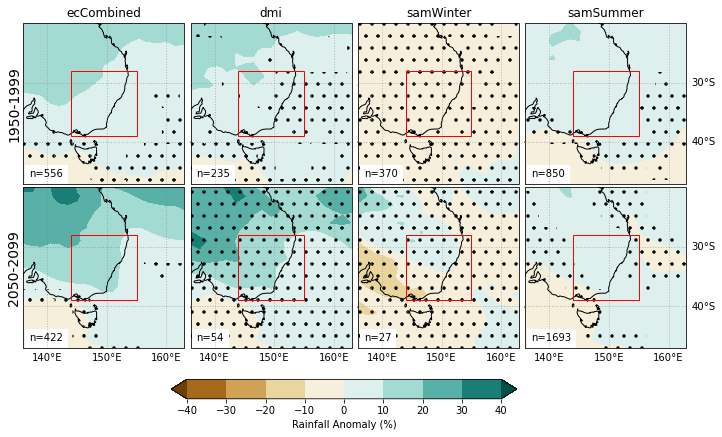

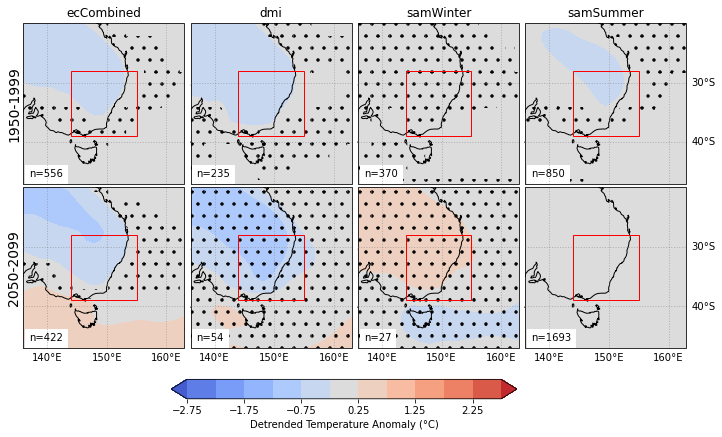

In [13]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=multiPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            maskXr.sel(fire=iFire,drop=True), #masks for event types
            eventsList, #names of event types
            cbarLabel='Rainfall Anomaly (%)'
        )
        plt.show()
        
        axs=multiPlotter(
            detrendTsXr[iSeason.capitalize()+' Temp'],
            maskXr.sel(fire=iFire,drop=True),
            eventsList,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        plt.show()

# ENSO index comparison

In [21]:
#eventsList=['ecCombined','nino34', 'eIndex','nino3','cIndex','nino4']
eventsList=['nino34', 'eIndex','cIndex']
maskXr = (fireEventsXr[eventsList]==1)
everythingXr=(fireEventsXr['nino34'].isnull()==False)
everythingXr.name='everything'

Fire:pos
winter


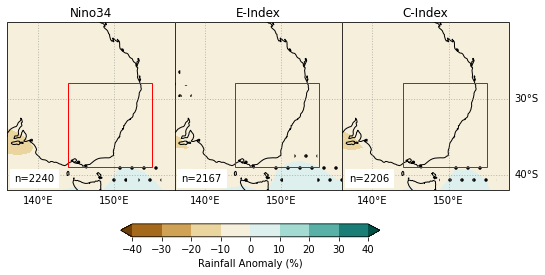

summer


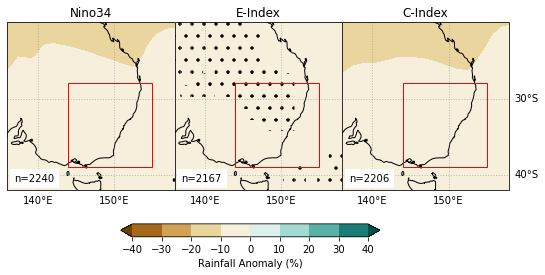

Fire:neg
winter


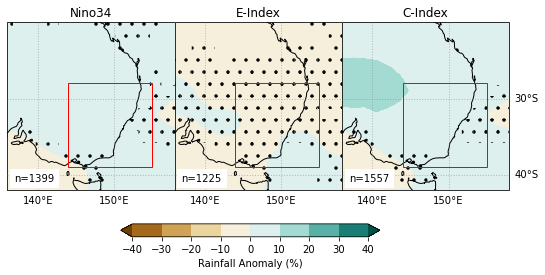

summer


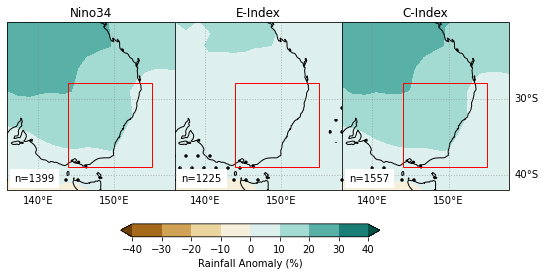

In [23]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=indexPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            maskXr.sel(fire=iFire,drop=True), #masks for event types
            eventsList, #names of event types
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].set_title('Nino34')
        axs[1].set_title('E-Index')
        axs[2].set_title('C-Index')
        plt.show()
        
        #axs=indexPlotter(
        #    detrendTsXr[iSeason.capitalize()+' Temp'],
        #    maskXr.sel(fire=iFire,drop=True),
        #    eventsList,
        #    cbarLabel='Detrended Temperature Anomaly (°C)'
        #)
        #axs[0].set_title('ENSO+IOD')
        #axs[1].set_title('ENSO+SAM')
        #axs[2].set_title('IOD+SAM')
        #axs[3].set_title('All3')
        #plt.show()

ACCESS-CM2
Fire:pos
1950-1999


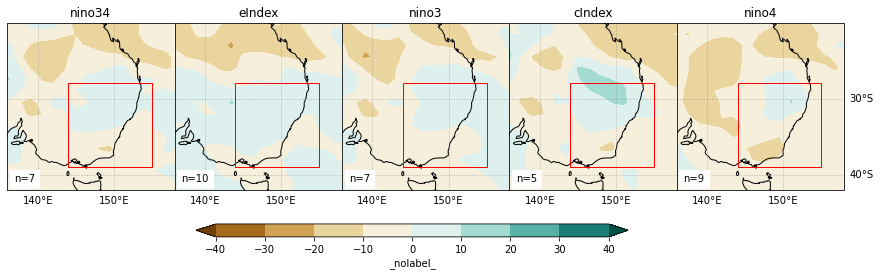

2050-2099


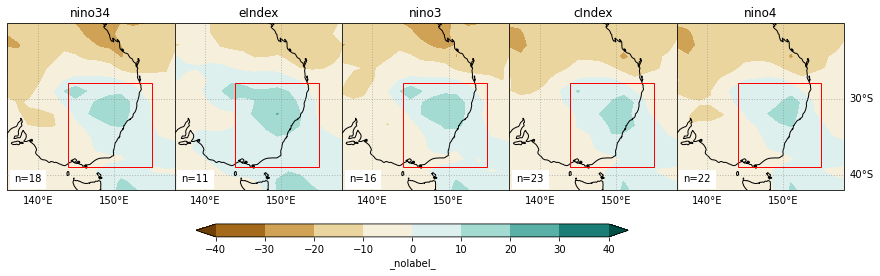

ACCESS-ESM1-5
Fire:pos
1950-1999


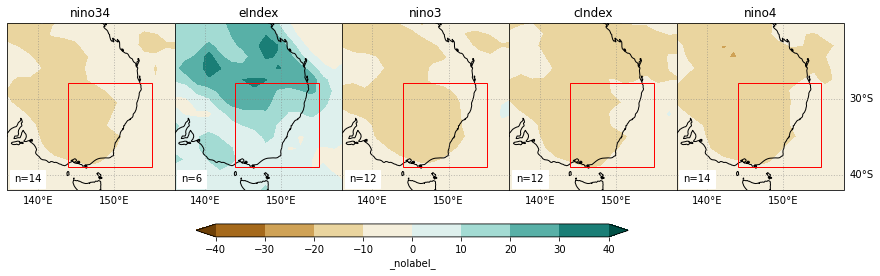

2050-2099


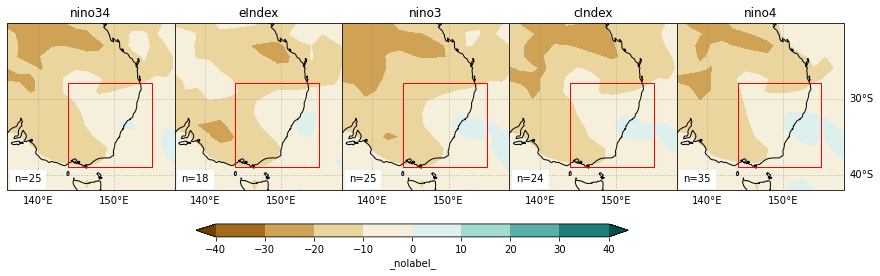

AWI-CM-1-1-MR
Fire:pos
1950-1999


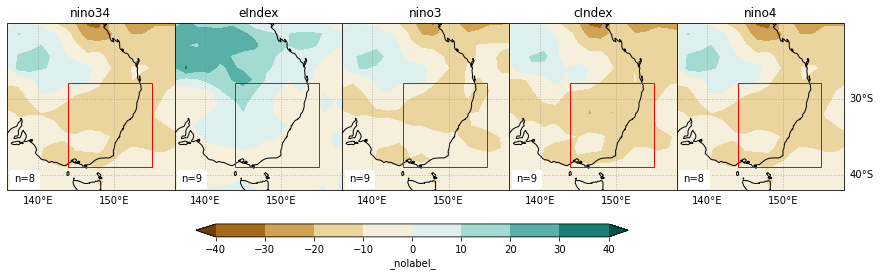

2050-2099


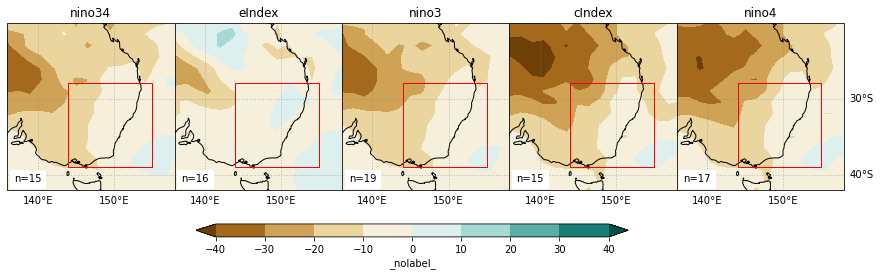

BCC-CSM2-MR
Fire:pos
1950-1999


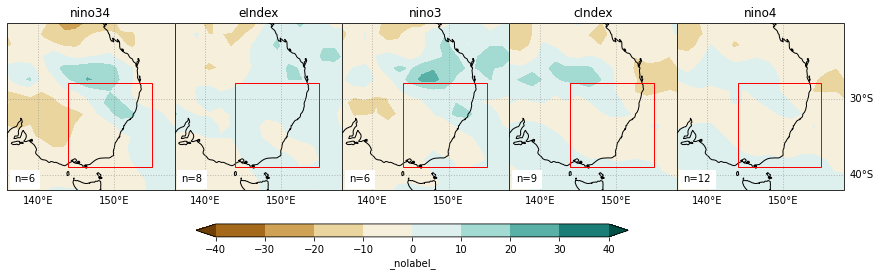

2050-2099


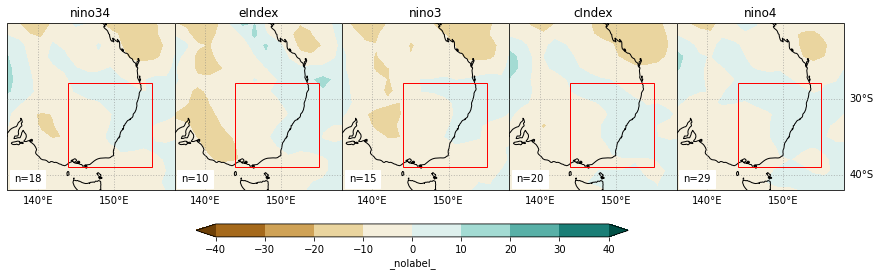

CAMS-CSM1-0
Fire:pos
1950-1999


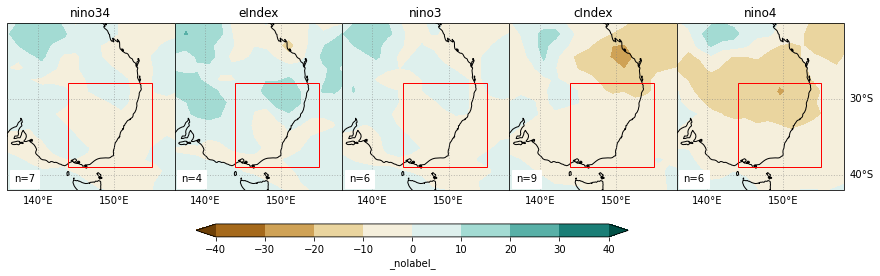

2050-2099


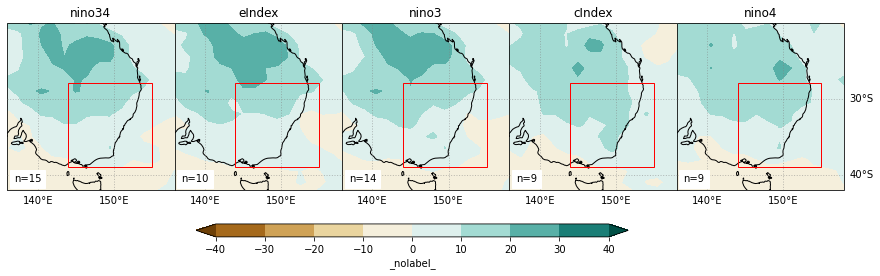

CAS-ESM2-0
Fire:pos
1950-1999


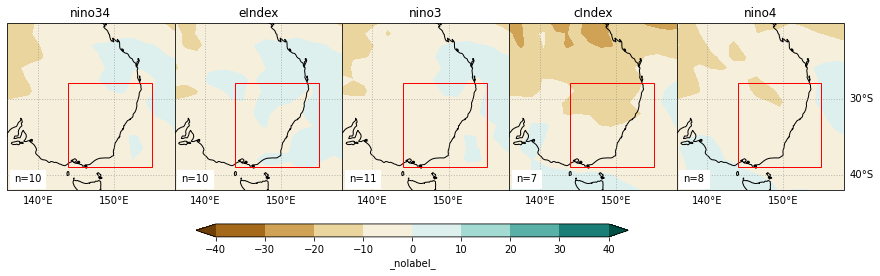

2050-2099


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


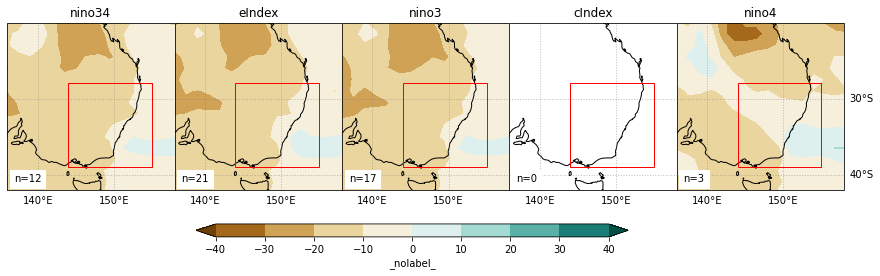

CESM2
Fire:pos
1950-1999


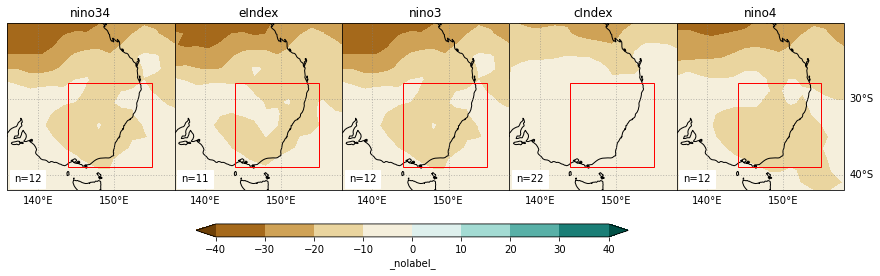

2050-2099


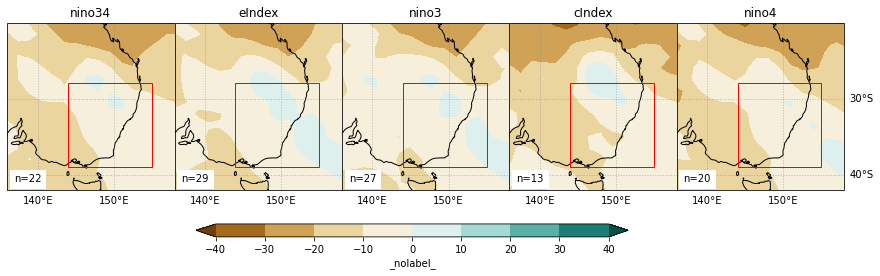

CESM2-WACCM
Fire:pos
1950-1999


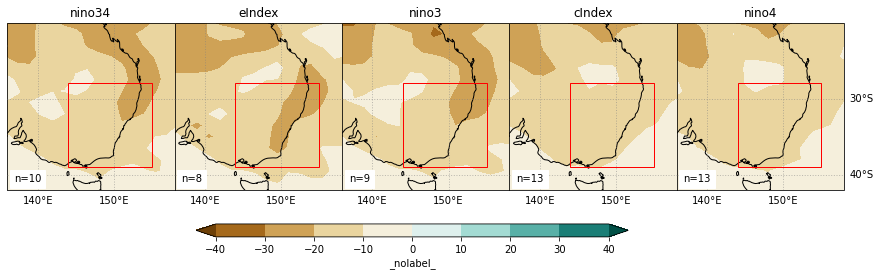

2050-2099


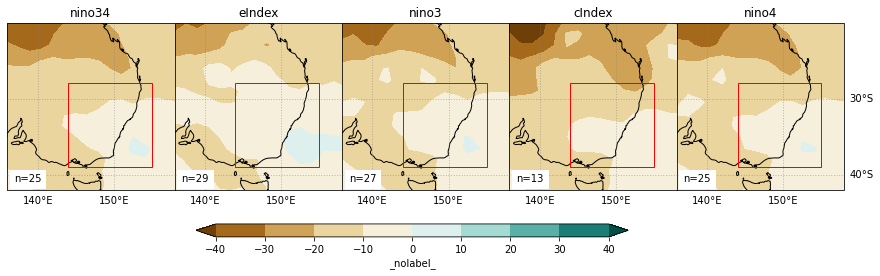

CIESM
Fire:pos
1950-1999


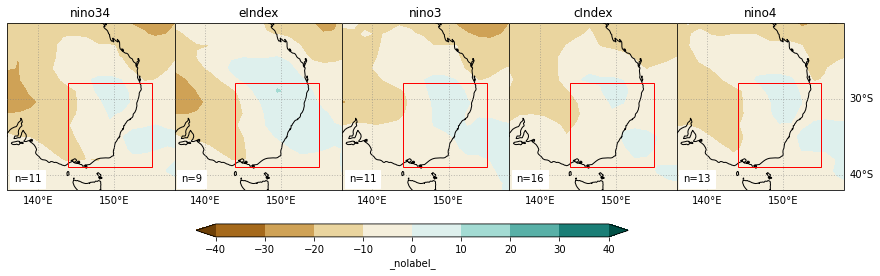

2050-2099


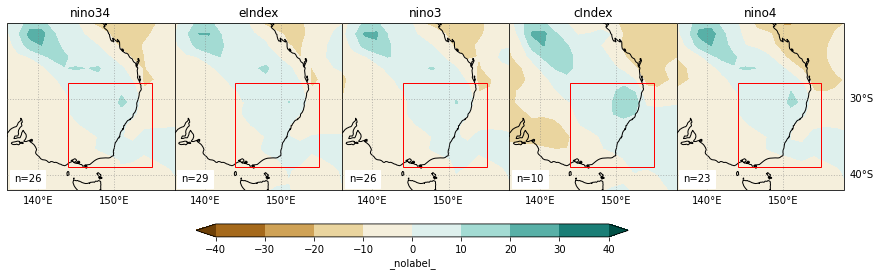

CMCC-CM2-SR5
Fire:pos
1950-1999


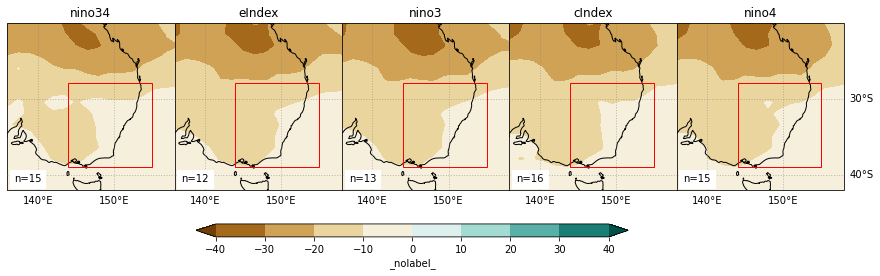

2050-2099


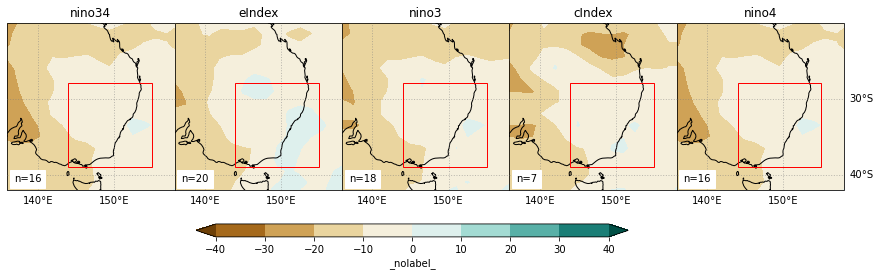

CMCC-ESM2
Fire:pos
1950-1999


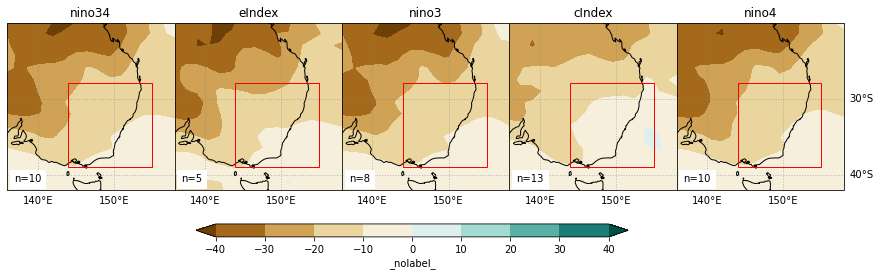

2050-2099


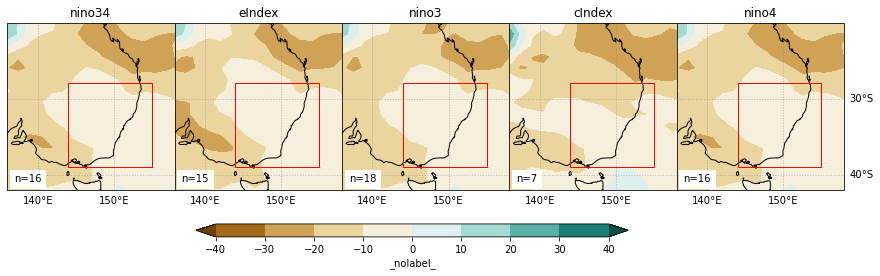

CNRM-CM6-1
Fire:pos
1950-1999


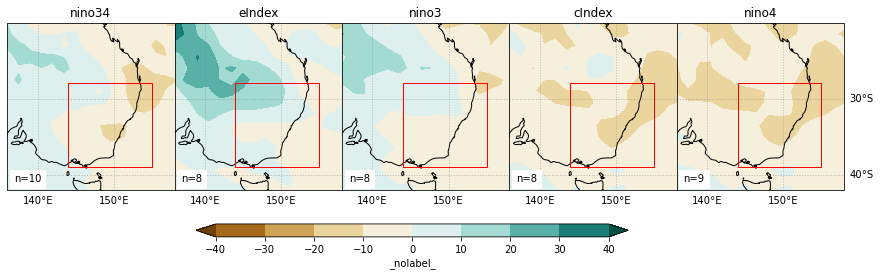

2050-2099


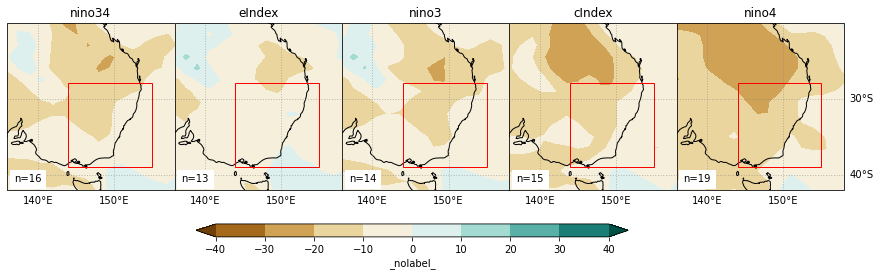

CNRM-ESM2-1
Fire:pos
1950-1999


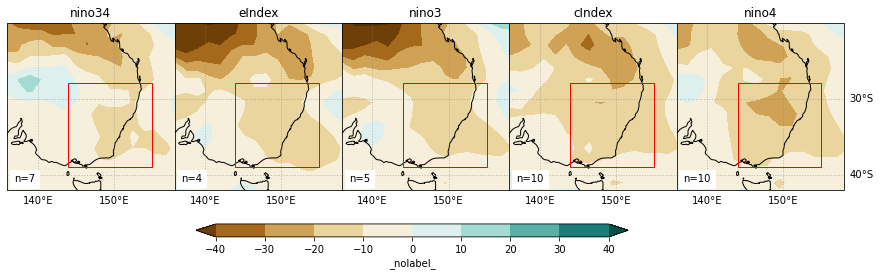

2050-2099


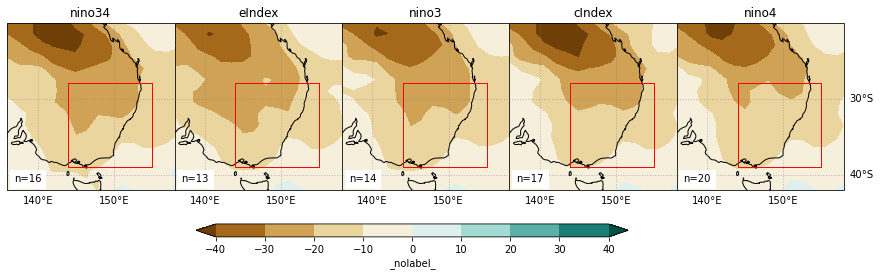

CanESM5
Fire:pos
1950-1999


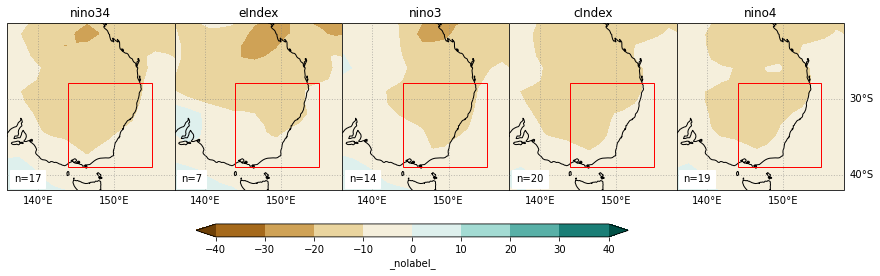

2050-2099


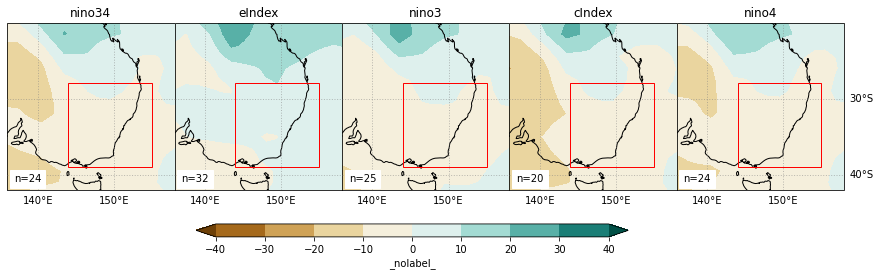

CanESM5-CanOE
Fire:pos
1950-1999


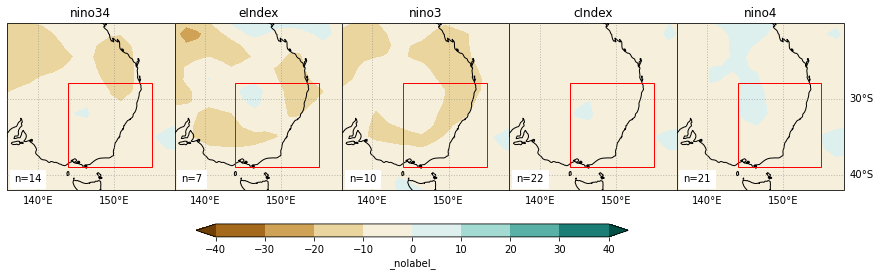

2050-2099


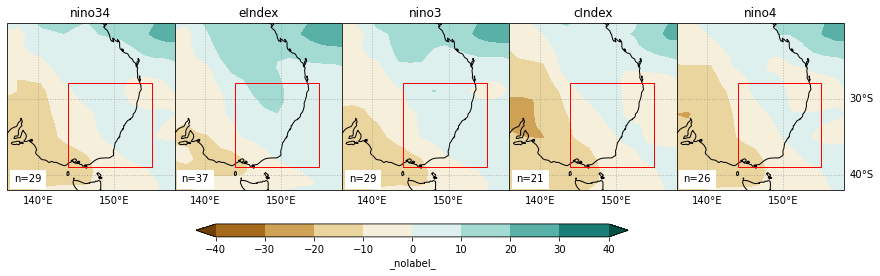

EC-Earth3
Fire:pos
1950-1999


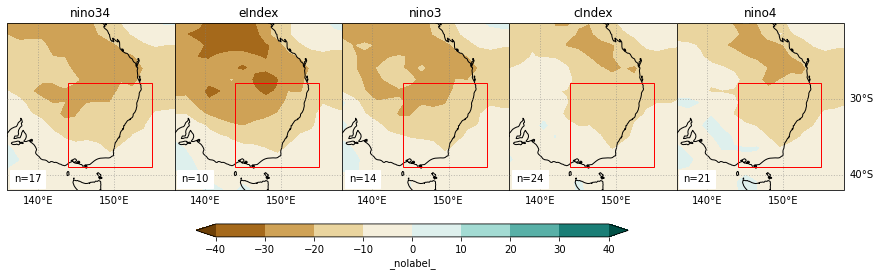

2050-2099


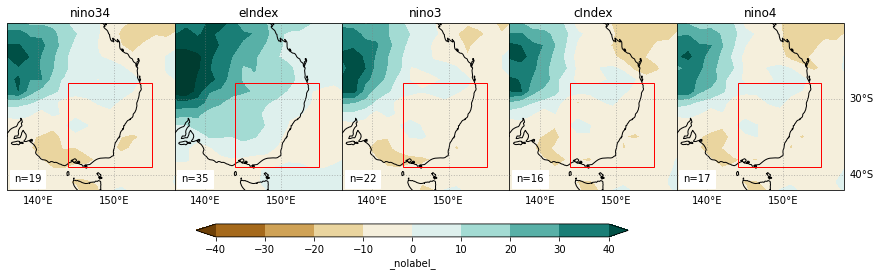

EC-Earth3-CC
Fire:pos
1950-1999


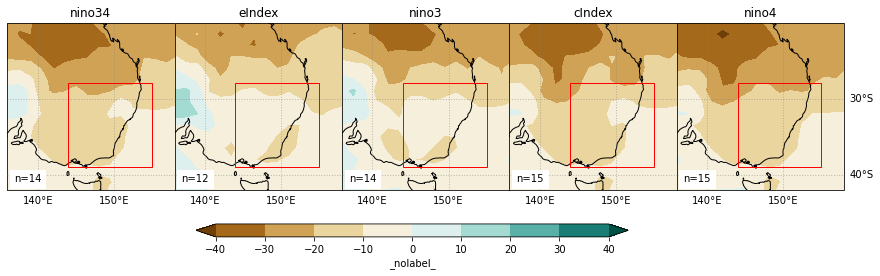

2050-2099


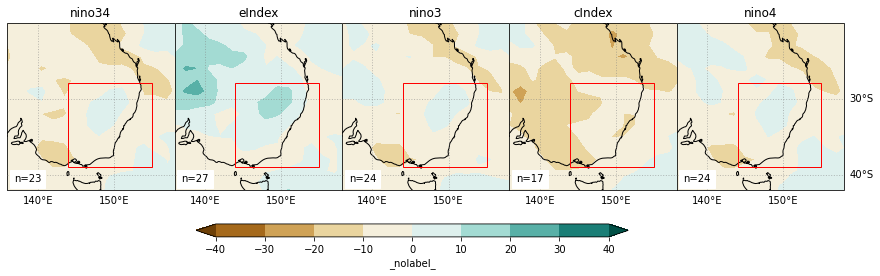

EC-Earth3-Veg
Fire:pos
1950-1999


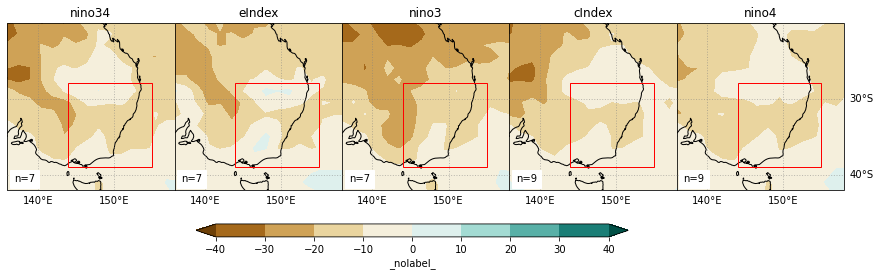

2050-2099


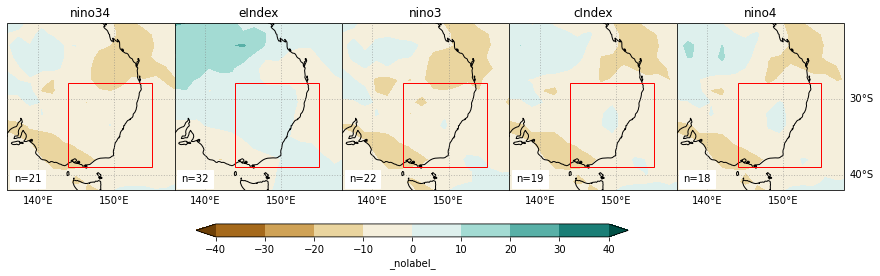

EC-Earth3-Veg-LR
Fire:pos
1950-1999


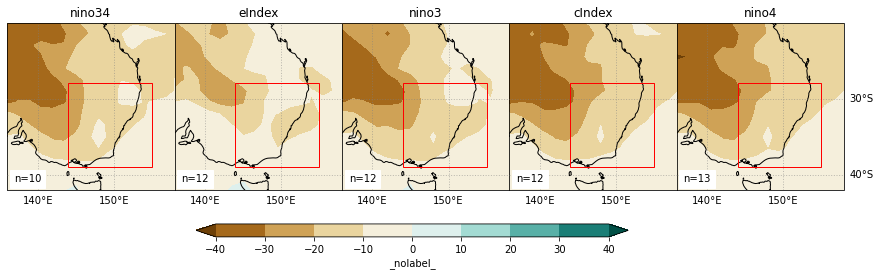

2050-2099


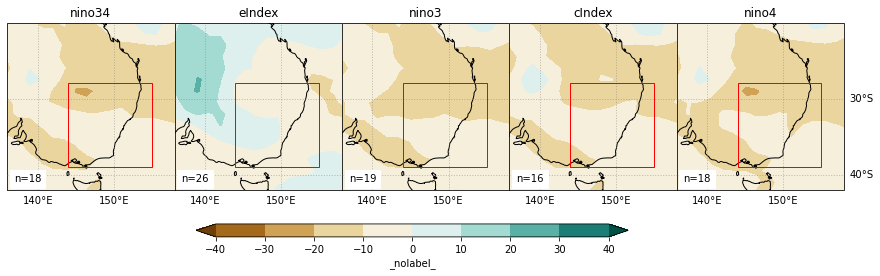

GFDL-CM4
Fire:pos
1950-1999


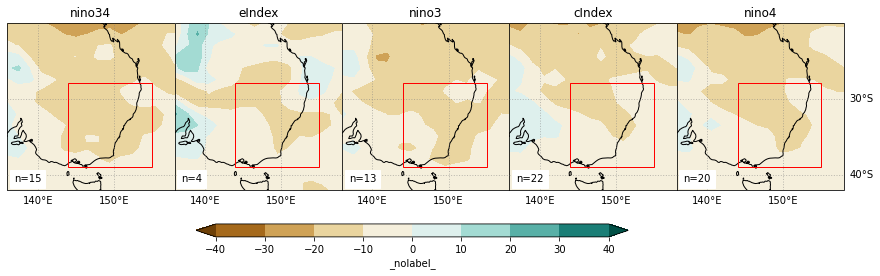

2050-2099


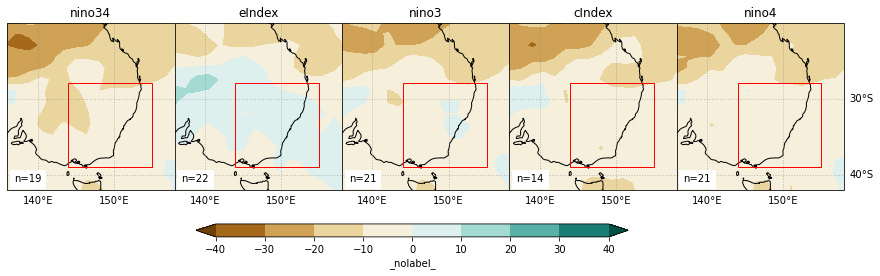

GFDL-ESM4
Fire:pos
1950-1999


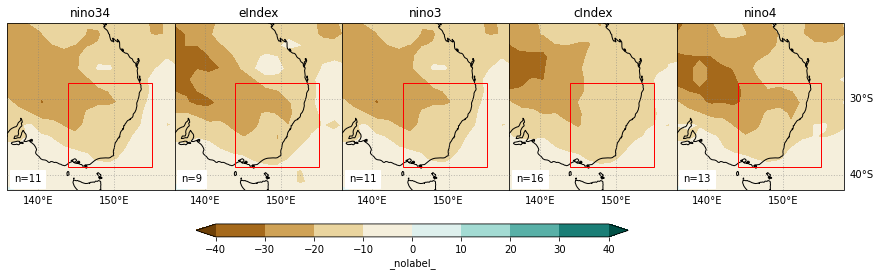

2050-2099


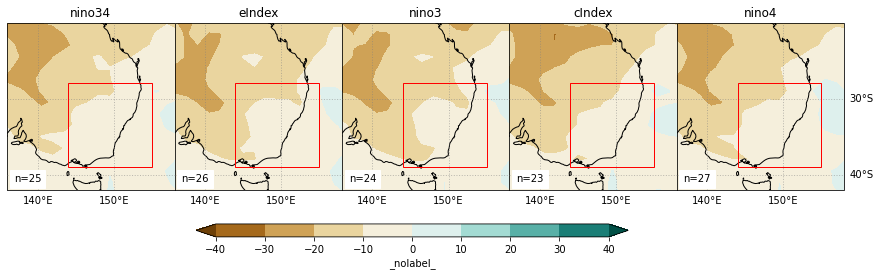

GISS-E2-1-G
Fire:pos
1950-1999


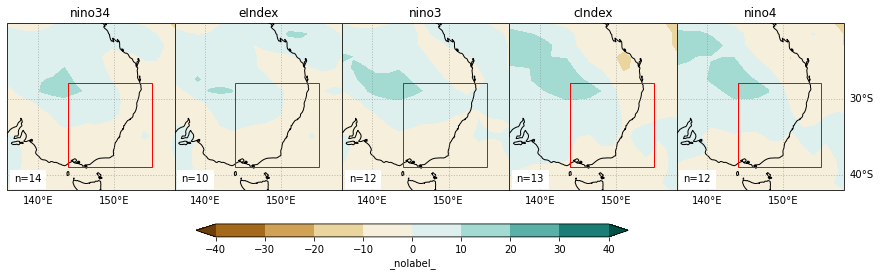

2050-2099


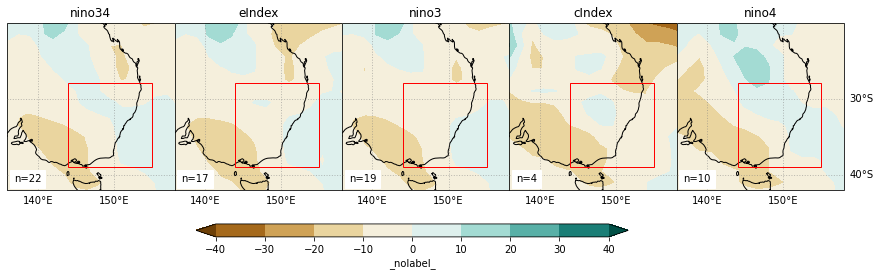

HadGEM3-GC31-LL
Fire:pos
1950-1999


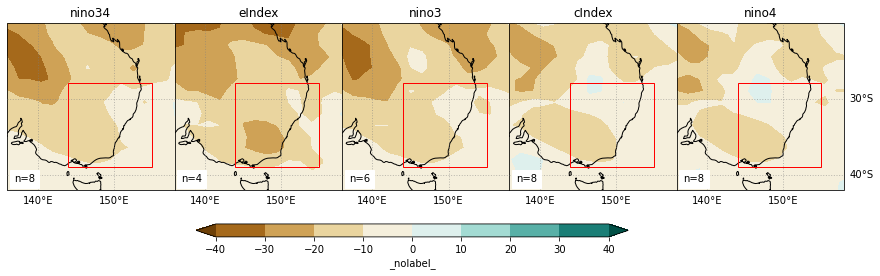

2050-2099


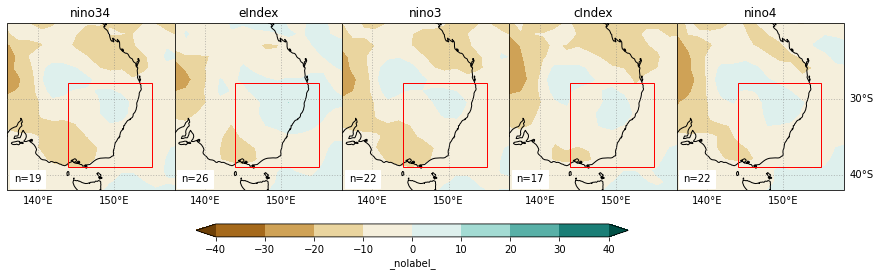

HadGEM3-GC31-MM
Fire:pos
1950-1999


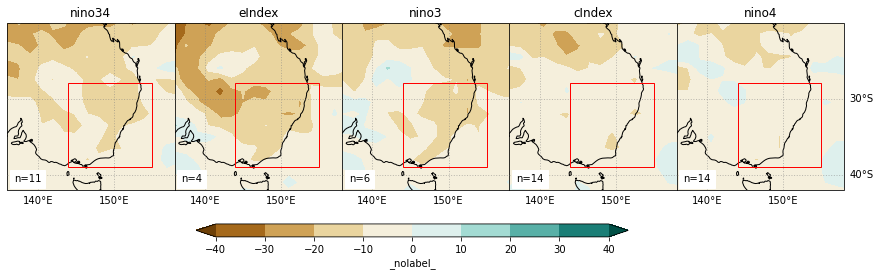

2050-2099


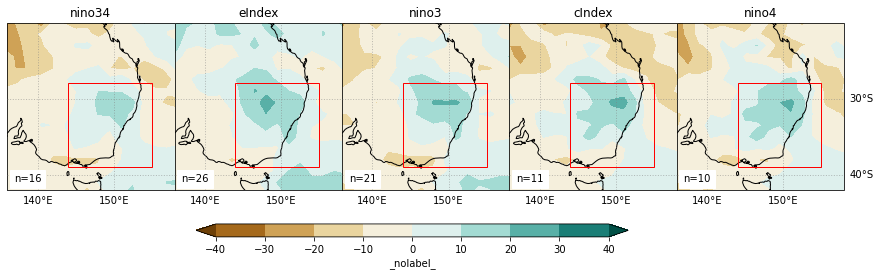

INM-CM4-8
Fire:pos
1950-1999


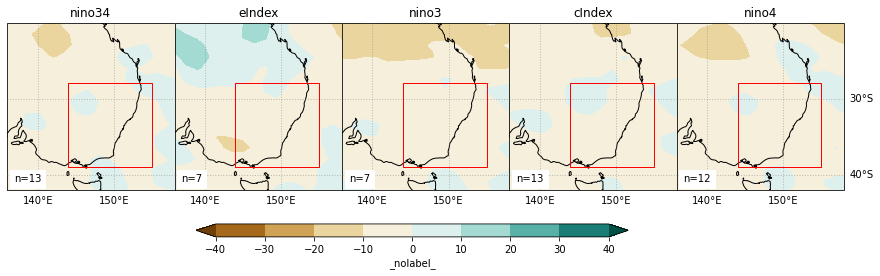

2050-2099


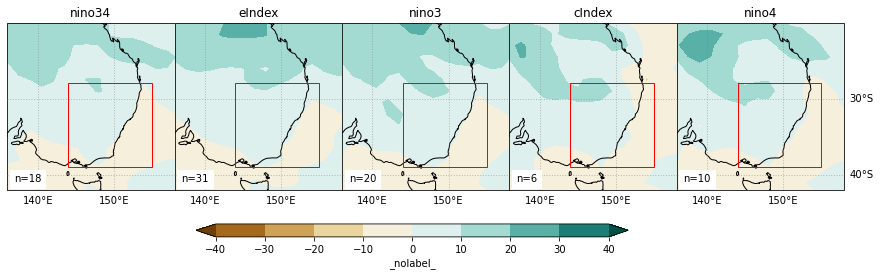

INM-CM5-0
Fire:pos
1950-1999


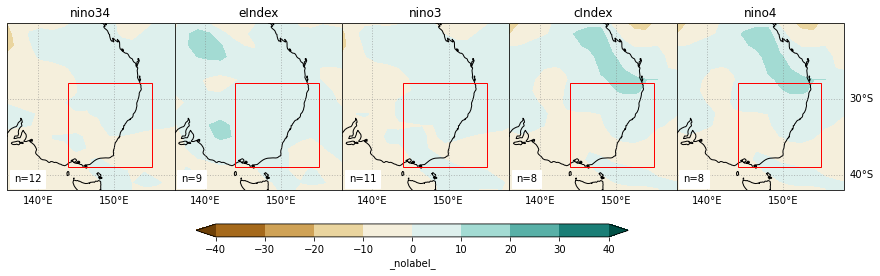

2050-2099


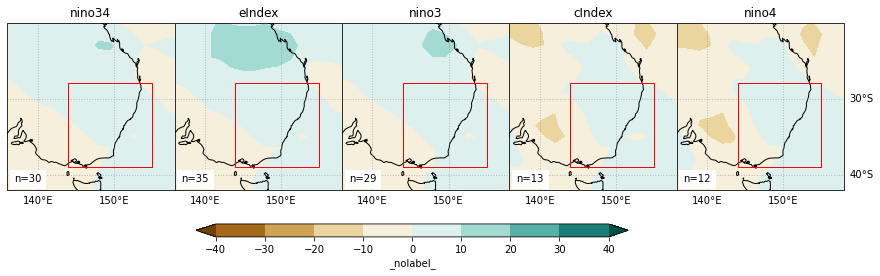

IPSL-CM6A-LR
Fire:pos
1950-1999


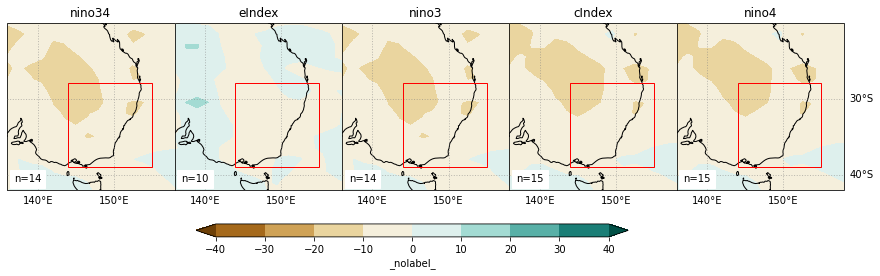

2050-2099


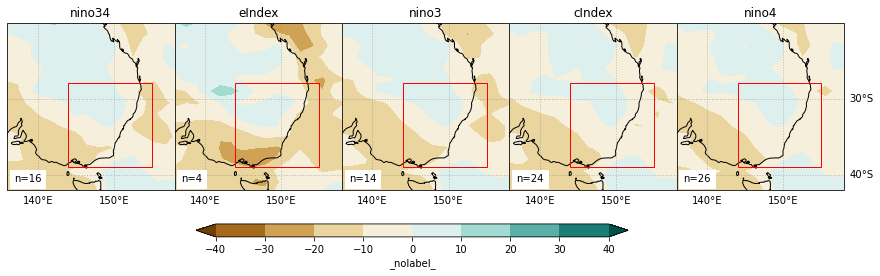

MCM-UA-1-0
Fire:pos
1950-1999


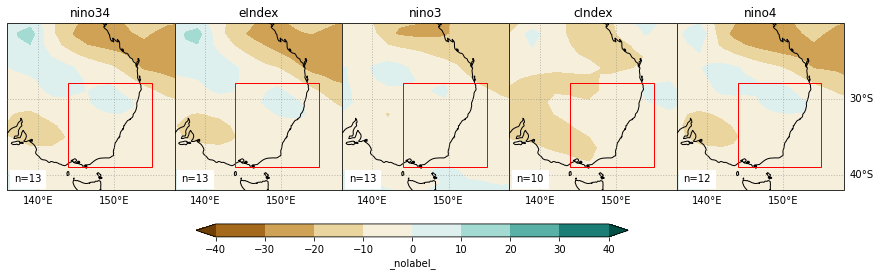

2050-2099


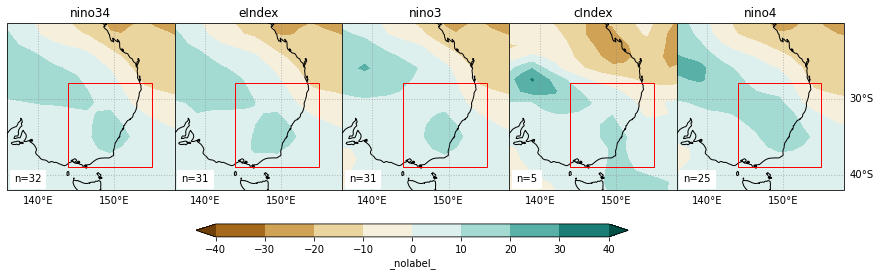

MIROC-ES2L
Fire:pos
1950-1999


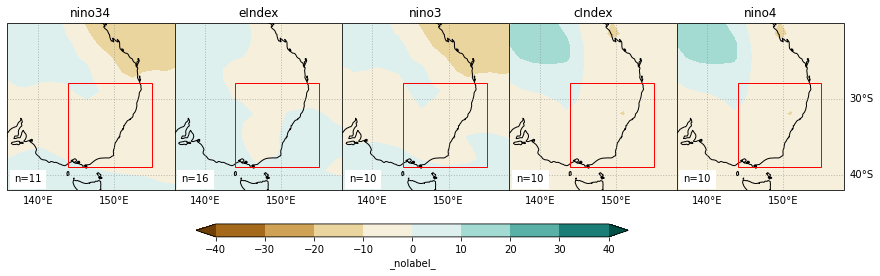

2050-2099


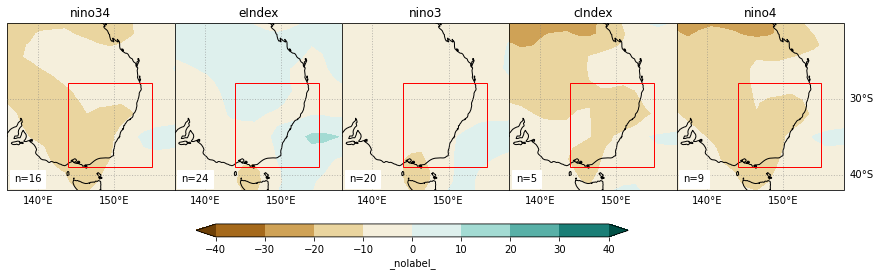

MIROC6
Fire:pos
1950-1999


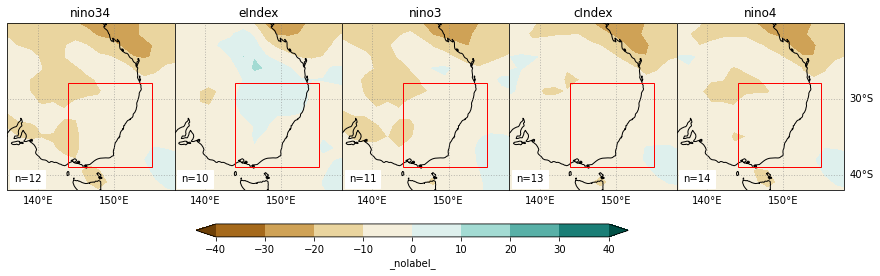

2050-2099


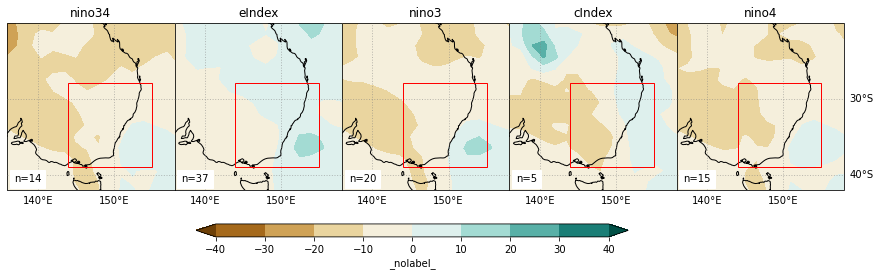

MPI-ESM1-2-HR
Fire:pos
1950-1999


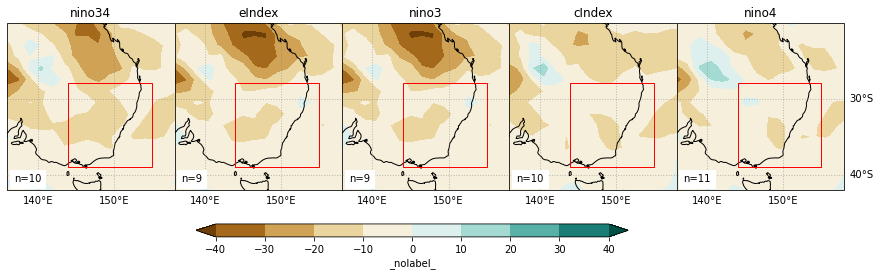

2050-2099


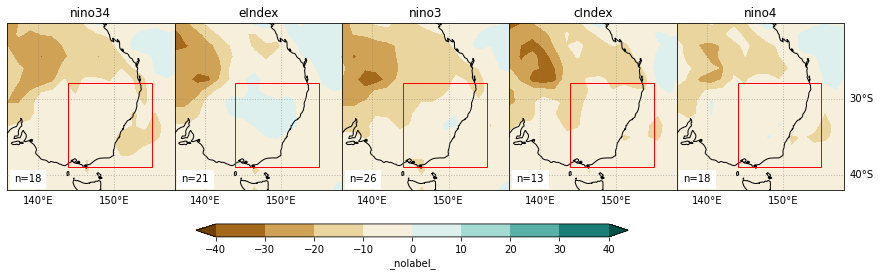

MPI-ESM1-2-LR
Fire:pos
1950-1999


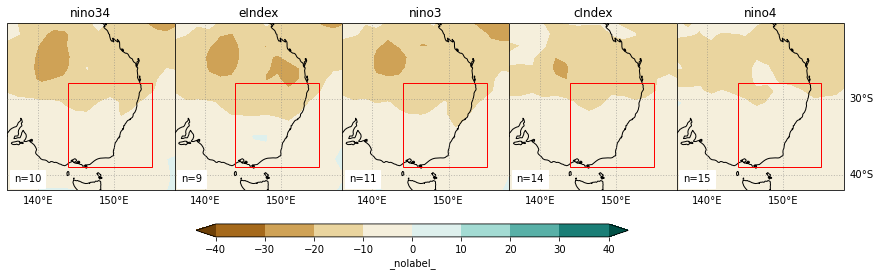

2050-2099


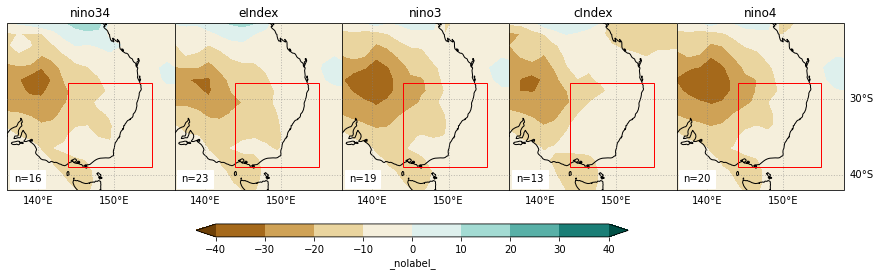

MRI-ESM2-0
Fire:pos
1950-1999


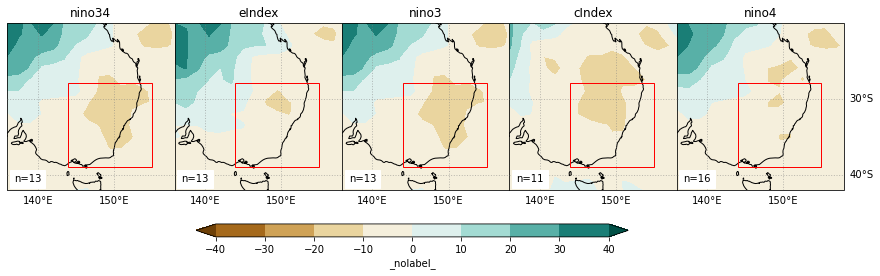

2050-2099


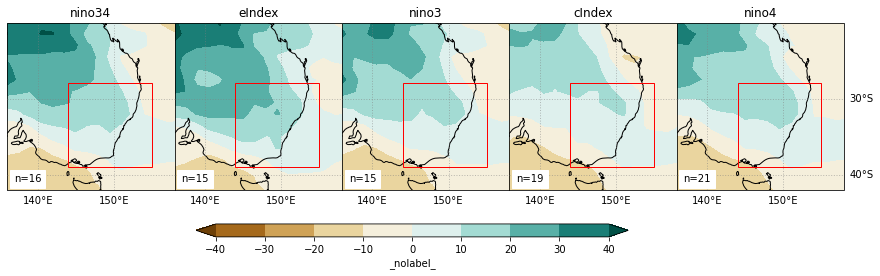

NESM3
Fire:pos
1950-1999


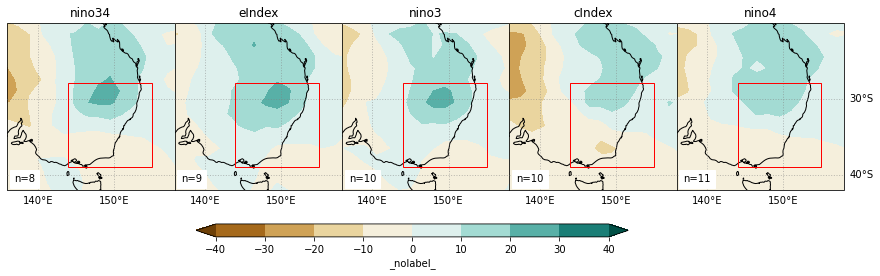

2050-2099


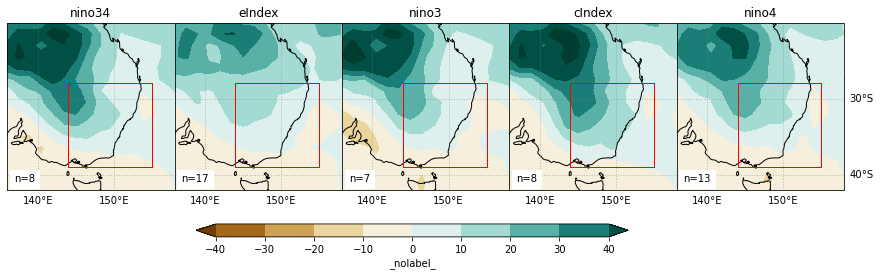

NorESM2-LM
Fire:pos
1950-1999


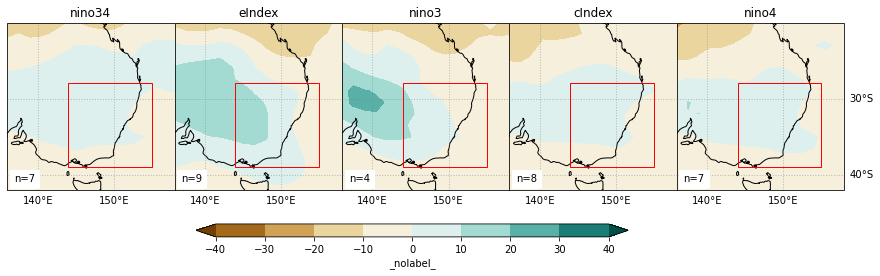

2050-2099


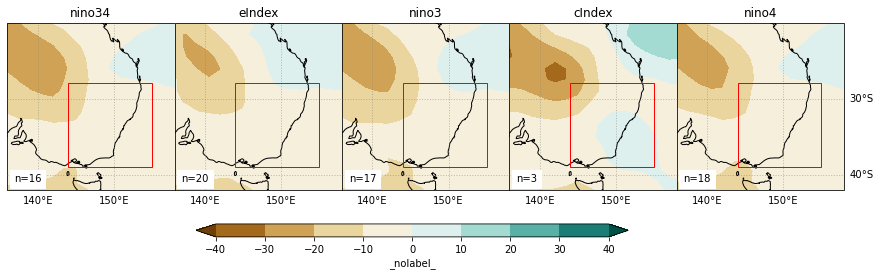

NorESM2-MM
Fire:pos
1950-1999


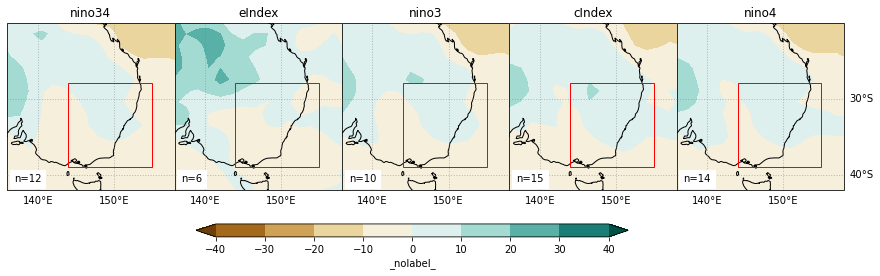

2050-2099


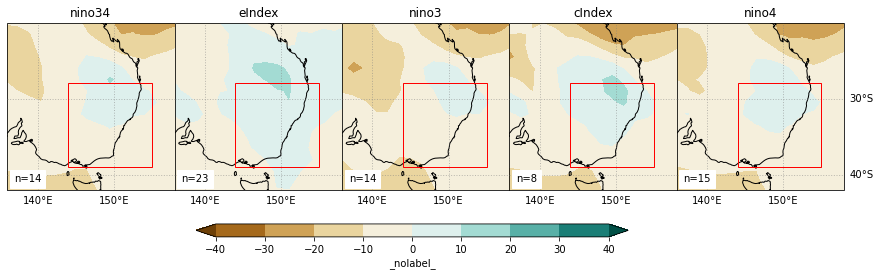

UKESM1-0-LL
Fire:pos
1950-1999


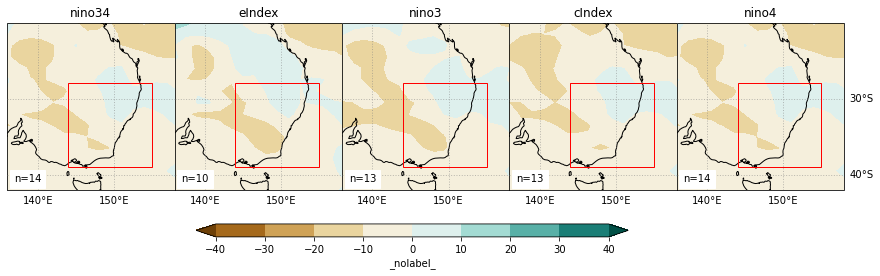

2050-2099


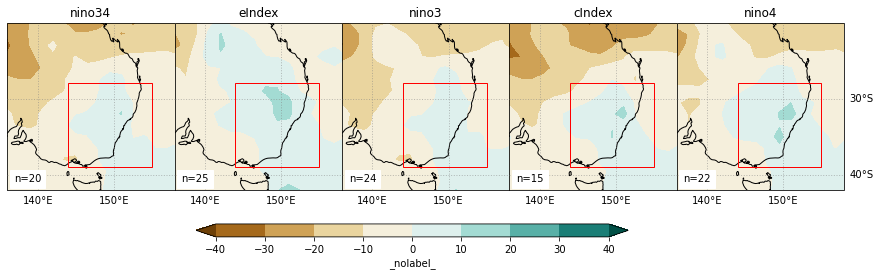

In [16]:
for iModel in prXr.model.values:
    print(iModel)
    for iFire in ['pos']:#,'neg']:
        print('Fire:'+iFire)
        for iSeason in [#'winter',
            'summer']:
            print('1950-1999')
            indexPlotter(
                prXr[iSeason.capitalize()+' Rain'].sel(model=iModel),
                maskXr.sel(fire=iFire,model=iModel,year=slice(1950,1999),drop=True), 
                eventsList,
                stipling=False
            )
            plt.show()
            print('2050-2099')
            indexPlotter(
                prXr[iSeason.capitalize()+' Rain'].sel(model=iModel),
                maskXr.sel(fire=iFire,model=iModel,year=slice(2050,2099),drop=True), 
                eventsList,
                stipling=False
            )
            plt.show()
            #indexPlotter(
            #    detrendXr['ts'+iSeason.capitalize()].sel(model=iModel),
            #    maskXr.sel(fire=iFire,model=iModel,drop=True), 
            #    eventsList,
            #)
            #plt.show()